In [1]:
from create_input_data import generate_input_data_simple_dataset
from two_bus_system import SimpleTwoBus
import pandapower as pp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

In [2]:
VM_PU_SLACK = 1.0  # Slack bus voltage magnitude
P_MW = 0.9  # Active power load at bus 2
Q_MVAR = 0.6  # Reactive power load at bus 2

R_PU = 0.01  # Resistance of the line
X_PU = 0.1  # Reactance of the line

In [3]:
# for idx in range(input_data.shape[0]):
grid_object = SimpleTwoBus(V_ext=VM_PU_SLACK, P=P_MW, Q=Q_MVAR, R=R_PU, X=X_PU)
try:
    pp.runpp(grid_object.net, max_iteration=50, init="flat")
except pp.powerflow.LoadflowNotConverged:
    print("Base case did not converge. Check the network setup.")

flat_start_solution_V = grid_object.net.res_bus[["vm_pu"]].values
flat_start_solution_angle = grid_object.net.res_bus[["va_degree"]].values
flat_start_solution_V, flat_start_solution_angle

(array([[1.        ],
        [0.92090496]]),
 array([[ 0.        ],
        [-5.23348739]]))

In [4]:
input_data = generate_input_data_simple_dataset(
    1000, INIT_VM_2_PU_MIN=0.5, INIT_VM_2_PU_MAX=2.0, INIT_THETA_2_DEGREE_MIN=-90, INIT_THETA_2_DEGREE_MAX=90
)

In [5]:
iteration_count_list = []
max_iterations = 20
for idx in range(input_data.shape[0]):
    v_init = [1.0, input_data[idx, 13]]
    theta_init = [0.0, input_data[idx, 15]]
    try:
        pp.runpp(
            grid_object.net,
            max_iteration=max_iterations,
            init="auto",
            init_vm_pu=v_init,
            init_va_degree=theta_init,
            tolerance_mva=1e-5,
        )
        # print(grid_object.net._ppc["iterations"])
        V_solution = grid_object.net.res_bus[["vm_pu"]].values
        theta_solution = grid_object.net.res_bus[["va_degree"]].values

        if (
            np.abs(V_solution[1] - flat_start_solution_V[1]) < 0.01
            and np.abs(theta_solution[1] - flat_start_solution_angle[1]) < 0.1
        ):
            iteration_count_list.append(grid_object.net._ppc["iterations"])
        else:
            iteration_count_list.append(max_iterations)
            # print("different Solution")
    except pp.powerflow.LoadflowNotConverged:
        iteration_count_list.append(max_iterations)
        # print("LoadflowNotConverged")

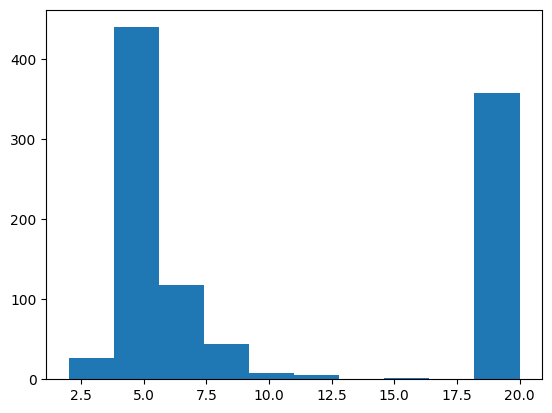

In [6]:
plt.hist(iteration_count_list)
plt.show()

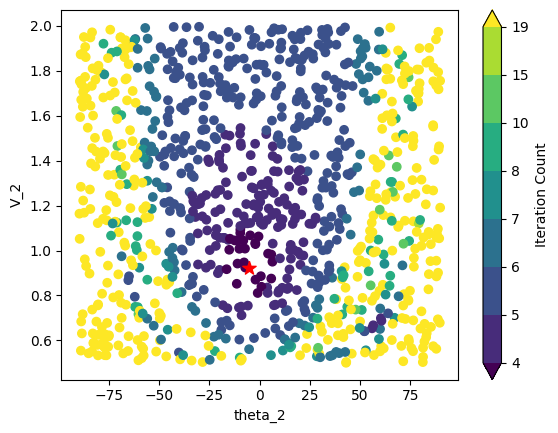

In [7]:
cmap = mpl.cm.viridis
bounds = [4, 5, 6, 7, 8, 10, 15, 19]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")

scatter = plt.scatter(input_data[:, 15], input_data[:, 13], c=iteration_count_list, cmap=cmap, norm=norm)
plt.scatter(flat_start_solution_angle[1], flat_start_solution_V[1], c="red", marker="*", s=100)
plt.xlabel("theta_2")
plt.ylabel("V_2")
plt.colorbar(scatter, label="Iteration Count")
plt.show()

In [8]:
Ybus = grid_object.net._ppc["internal"]["Ybus"].todense()
input_data[:, 4:8] = Ybus.real.flatten()
input_data[:, 8:12] = Ybus.imag.flatten()
print(input_data[:5, :])

[[ 0.00000000e+00  9.00000000e-01  0.00000000e+00  6.00000000e-01
   9.90099010e-01 -9.90099010e-01 -9.90099010e-01  9.90099010e-01
  -9.90099010e+00  9.90099010e+00  9.90099010e+00 -9.90099010e+00
   1.00000000e+00  6.99093459e-01  0.00000000e+00  6.03748456e+01
   1.00000000e-02  1.00000000e-01]
 [ 0.00000000e+00  9.00000000e-01  0.00000000e+00  6.00000000e-01
   9.90099010e-01 -9.90099010e-01 -9.90099010e-01  9.90099010e-01
  -9.90099010e+00  9.90099010e+00  9.90099010e+00 -9.90099010e+00
   1.00000000e+00  1.93954172e+00  0.00000000e+00  1.75169089e+01
   1.00000000e-02  1.00000000e-01]
 [ 0.00000000e+00  9.00000000e-01  0.00000000e+00  6.00000000e-01
   9.90099010e-01 -9.90099010e-01 -9.90099010e-01  9.90099010e-01
  -9.90099010e+00  9.90099010e+00  9.90099010e+00 -9.90099010e+00
   1.00000000e+00  1.76144013e+00  0.00000000e+00 -6.67738284e+01
   1.00000000e-02  1.00000000e-01]
 [ 0.00000000e+00  9.00000000e-01  0.00000000e+00  6.00000000e-01
   9.90099010e-01 -9.90099010e-01 -9.

In [9]:
output_data = np.hstack([np.array(iteration_count_list)])

In [10]:
full_dataset = np.hstack([input_data, output_data.reshape(-1, 1)])
full_dataset

array([[0.e+00, 9.e-01, 0.e+00, ..., 1.e-02, 1.e-01, 4.e+00],
       [0.e+00, 9.e-01, 0.e+00, ..., 1.e-02, 1.e-01, 5.e+00],
       [0.e+00, 9.e-01, 0.e+00, ..., 1.e-02, 1.e-01, 2.e+01],
       ...,
       [0.e+00, 9.e-01, 0.e+00, ..., 1.e-02, 1.e-01, 2.e+01],
       [0.e+00, 9.e-01, 0.e+00, ..., 1.e-02, 1.e-01, 8.e+00],
       [0.e+00, 9.e-01, 0.e+00, ..., 1.e-02, 1.e-01, 2.e+01]])

In [11]:
with open("full_dataset.pkl", "wb") as f:
    pickle.dump(full_dataset, f)